In [15]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
import essentia, essentia.standard as ess
import numpy as np
import librosa.display
import signal
plt.rcParams['figure.figsize'] = (14,4)

from scipy.signal import butter, lfilter, freqz

import glob
from pathlib import Path, PurePath

filelist = []

for filename in Path('music').glob('**/*.mp3'):
    filelist.append(filename)
    
for filename in Path('music').glob('**/*.wav'):
    filelist.append(filename)
    
path = str(PurePath(filelist[4]))

path = ('music/guitar2.mp3')

print(path)

x, fs = librosa.load(path)
#x = x[:fs*30]
mfcc = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=12)


music/guitar2.mp3


In [16]:
def extract_mfcc(x, fs):
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=12)
    mean = numpy.mean(mfcc, axis=1)
    #print(mean)
    var = numpy.var(mfcc, axis=1)
    #print(var)
    cov = numpy.cov(mfcc)
    
    #get only upper triangular matrix values to shorten length
    iu1 = np.triu_indices(12)
    cov = cov[iu1]
    
    return mean, cov

In [17]:
print(extract_mfcc(x, fs))

(array([-424.79174724,  106.48709155,  -17.7724664 ,   -1.5367994 ,
          7.52920526,  -15.07432829,  -10.99313413,    2.14699144,
          2.59203807,    5.47147963,    2.64506454,   -8.90593684]), array([ 1.07039739e+04,  5.58305571e+03, -2.72340045e+03,  1.21412478e+01,
        3.72857621e+02, -9.11781246e+02, -3.14101285e+02,  3.16091239e+02,
       -8.23816656e+01,  2.76396812e+01,  6.37727123e+01, -5.98624224e+02,
        3.88586452e+03, -4.61455896e+02, -9.97074491e+01,  3.00149273e+02,
       -1.53370025e+02, -2.21654565e+02, -2.17362465e+02, -3.02728178e+02,
       -6.70584917e+01,  7.56281236e+01, -1.68166837e+02,  1.90638247e+03,
        4.63875093e+01, -1.95188990e+01,  7.16930811e+02,  7.05678946e+01,
       -5.36908408e+02, -3.33542525e+02, -1.61837325e+02,  6.03521500e+01,
        3.43448050e+02,  1.99666920e+02,  6.26630208e+01,  8.60587449e+01,
        3.97876207e+01, -5.90609083e+01, -1.23613885e+02, -6.89395661e+01,
        7.12375433e+01,  6.44510647e+01,  1.67

In [18]:
#filter audio signal

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = fs
cutoff_hp = 128  # desired cutoff frequency of the filter, Hz
cutoff_lp = 4096  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_highpass(cutoff_hp, fs, order)

data = x

# Filter the data, and plot both the original and filtered signals.
x_hp_filtered = butter_highpass_filter(data, cutoff_hp, fs, order)

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff_lp, fs, order)

data = x_hp_filtered

# Filter the data, and plot both the original and filtered signals.
x_lp_filtered = butter_lowpass_filter(data, cutoff_lp, fs, order)

IPython.display.Audio(x_lp_filtered, rate=fs)
#chroma features for "melody only" highpass filtered audio data

#original audio signal - extract max chroma key only
chroma = librosa.feature.chroma_stft(x_hp_filtered, fs)

3.4635941581857086
135.99917763157896
[0, 9, 6, 2, 2, 6, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 7, 0, 3]


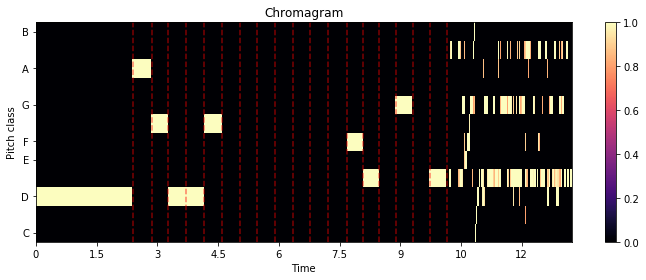

In [19]:
chroma = librosa.feature.chroma_stft(x, fs)

threshold = 300
m, n = chroma.shape

avg = 0
chroma = chroma.transpose()
m, n = chroma.shape

for j in chroma:
    avg = avg + np.sum(j)
    
avg = avg / m
threshold = avg 

print(threshold)

for i in chroma:
    if np.sum(i) > threshold:
        ind = np.where(i == np.max(i))
        max_val = i[ind]#is always 1!
        i[ind] = 0
        
        ind2 = np.where(i == np.max(i))
        i[ind] = 1
        
        if np.any(i[ind2] >= 0.8 * max_val):
            #i[ind2] = i[ind2]
            pass
        #low_values_flags = i < 1
        low_values_flags = i < 0.8
        
        i[low_values_flags] = 0
    else:
        i.fill(0)     
        
chroma = chroma.transpose()        

tempo, beats = librosa.beat.beat_track(x, fs)#
print(tempo)
onset_env = librosa.onset.onset_strength(x, fs, aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,sr=fs)
hop_length = 512
times = librosa.frames_to_time(np.arange(len(onset_env)), sr=fs, hop_length=hop_length)

prev_beat = 0
act_beat = 0
sum_key = np.zeros(12)

chroma = chroma.transpose()  

for i in beats:
    act_beat = i
    sum_key = sum(chroma[prev_beat:act_beat])
    #print(sum_key)
    #print(chroma[prev_beat:act_beat])

    ind = np.where(sum_key == np.max(sum_key))
    ind = ind[0]
    #print("debug")
    fill = np.zeros(len(j))
    if(np.all(chroma[prev_beat:act_beat] == 0)):
        fill[ind] = 0
    else:    
        fill[ind] = 1
    chroma[prev_beat:act_beat] = fill
    #print(chroma[prev_beat:act_beat])
    prev_beat = i
    #print("BEAT")


chroma = chroma.transpose()  
    
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.vlines(times[beats], 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

chroma = chroma.transpose()  

notes = []
for i in notes:
    del i

for i in beats:
    act_beat = i
    sum_key = sum(chroma[prev_beat:act_beat])
    ind = np.where(sum_key == np.max(sum_key))
    prev_beat = i
    notes.append(ind[0][0])
  
#chroma = chroma.transpose()  
print(notes)

In [20]:
def extract_chroma(x, fs):
    # Filter requirements.
    order = 6
    fs = fs
    cutoff_hp = 128  # desired cutoff frequency of the filter, Hz
    cutoff_lp = 4096  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff_hp, fs, order)
    data = x

    # Filter the data, and plot both the original and filtered signals.
    x_hp_filtered = butter_highpass_filter(data, cutoff_hp, fs, order)

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff_lp, fs, order)

    data = x_hp_filtered

    # Filter the data, and plot both the original and filtered signals.
    x_lp_filtered = butter_lowpass_filter(data, cutoff_lp, fs, order)

    IPython.display.Audio(x_lp_filtered, rate=fs)
    #chroma features for "melody only" highpass filtered audio data

    #original audio signal - extract max chroma key only
    chroma = librosa.feature.chroma_stft(x_hp_filtered, fs)
    avg = 0
    
    chroma = chroma.transpose()
    m, n = chroma.shape

    for j in chroma:
        avg = avg + np.sum(j)

    avg = avg / m
    threshold = avg * 2 

    for i in chroma:
        if np.sum(i) < threshold:
            ind = np.where(i == np.max(i))
            max_val = i[ind]#is always 1!
            i[ind] = 0

            ind2 = np.where(i == np.max(i))
            i[ind] = 1

            if np.any(i[ind2] >= 0.8 * max_val):
                #i[ind2] = i[ind2]
                pass
            #low_values_flags = i < 1
            low_values_flags = i < 0.8

            i[low_values_flags] = 0
        else:
            i.fill(0)         

    tempo, beats = librosa.beat.beat_track(x, fs)#
    #print(tempo)
    onset_env = librosa.onset.onset_strength(x, fs, aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,sr=fs)
    hop_length = 512
    times = librosa.frames_to_time(np.arange(len(onset_env)), sr=fs, hop_length=hop_length)

    prev_beat = 0
    act_beat = 0
    sum_key = np.zeros(12)

    for i in beats:
        act_beat = i
        sum_key = sum(chroma[prev_beat:act_beat])
        #print(sum_key)
        #print(chroma[prev_beat:act_beat])

        ind = np.where(sum_key == np.max(sum_key))
        ind = ind[0]
        #print("debug")
        fill = np.zeros(len(j))
        if(np.all(chroma[prev_beat:act_beat] == 0)):
            fill[ind] = 0
        else:    
            fill[ind] = 1
        chroma[prev_beat:act_beat] = fill
        #print(chroma[prev_beat:act_beat])
        prev_beat = i
        #print("BEAT")


    notes = []
    for i in notes:
        del i

    for i in beats:
        act_beat = i
        sum_key = sum(chroma[prev_beat:act_beat])
        ind = np.where(sum_key == np.max(sum_key))
        prev_beat = i
        notes.append(ind[0][0])

    chroma = chroma.transpose()  
    
    return tempo, notes

In [21]:
print(extract_chroma(x, fs))

(135.99917763157896, [0, 9, 6, 2, 6, 2, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7])


In [22]:
extract_mfcc(x, fs)

(array([-424.79174724,  106.48709155,  -17.7724664 ,   -1.5367994 ,
           7.52920526,  -15.07432829,  -10.99313413,    2.14699144,
           2.59203807,    5.47147963,    2.64506454,   -8.90593684]),
 array([ 1.07039739e+04,  5.58305571e+03, -2.72340045e+03,  1.21412478e+01,
         3.72857621e+02, -9.11781246e+02, -3.14101285e+02,  3.16091239e+02,
        -8.23816656e+01,  2.76396812e+01,  6.37727123e+01, -5.98624224e+02,
         3.88586452e+03, -4.61455896e+02, -9.97074491e+01,  3.00149273e+02,
        -1.53370025e+02, -2.21654565e+02, -2.17362465e+02, -3.02728178e+02,
        -6.70584917e+01,  7.56281236e+01, -1.68166837e+02,  1.90638247e+03,
         4.63875093e+01, -1.95188990e+01,  7.16930811e+02,  7.05678946e+01,
        -5.36908408e+02, -3.33542525e+02, -1.61837325e+02,  6.03521500e+01,
         3.43448050e+02,  1.99666920e+02,  6.26630208e+01,  8.60587449e+01,
         3.97876207e+01, -5.90609083e+01, -1.23613885e+02, -6.89395661e+01,
         7.12375433e+01,  6.445106

('BPM:', 96.7677001953125)
Overall BPM (estimated before): 96.8
First histogram peak: 98.0 bpm
Second histogram peak: 92.0 bpm


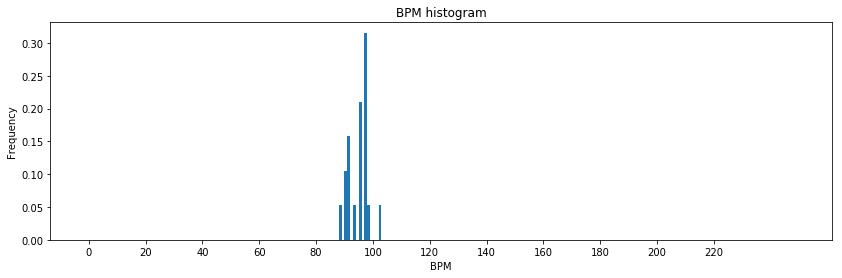

In [23]:
import essentia
import essentia.standard as es
from essentia.standard import *

fs = 44100

path = 'music/guitar2.mp3'

# Loading audio file
audio = MonoLoader(filename=path, sampleRate=fs)()

#analysis sample rate (audio will be converted to it before analysis, recommended and default value is 44100.0)
# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'])(path)

# See all feature names in the pool in a sorted order
#print("MFCC mean:", features['lowlevel.mfcc.mean'])
#print("MFCC mean:", features['lowlevel.mfcc.cov'])

# Compute beat positions and BPM
rhythm_extractor = RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)

print("BPM:", bpm)
#print("Beat positions (sec.):", beats)
#print("Beat estimation confidence:", beats_confidence)

# Mark beat positions on the audio and write it to a file
# Let's use beeps instead of white noise to mark them, as it's more distinctive
#marker = AudioOnsetsMarker(onsets=beats, type='beep')
#marked_audio = marker(audio)
#MonoWriter(filename='music/dubstep_beats.wav')(marked_audio)

peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)

print("Overall BPM (estimated before): %0.1f" % bpm)
print("First histogram peak: %0.1f bpm" % peak1_bpm)
print("Second histogram peak: %0.1f bpm" % peak2_bpm)

fig, ax = plt.subplots()
ax.bar(range(len(histogram)), histogram, width=1)
ax.set_xlabel('BPM')
ax.set_ylabel('Frequency')
plt.title("BPM histogram")
ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
plt.show()

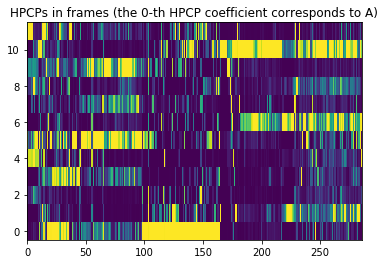

('Estimated key and scale:', 'G minor')


In [24]:
import essentia.streaming as ess
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt

# Initialize algorithms we will use

frameSize = 4096#512
hopSize = 2048#256

#will resample if sampleRate is different!
loader = ess.MonoLoader(filename=path, sampleRate=44100)
framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
windowing = ess.Windowing(type='blackmanharris62')
spectrum = ess.Spectrum()
spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                  magnitudeThreshold=0.00001,
                                  minFrequency=20,
                                  maxFrequency=3500,
                                  maxPeaks=60)

# Use default HPCP parameters for plots, however we will need higher resolution
# and custom parameters for better Key estimation

hpcp = ess.HPCP()
hpcp_key = ess.HPCP(size=36, # we will need higher resolution for Key estimation
                    referenceFrequency=440, # assume tuning frequency is 44100.
                    bandPreset=False,
                    minFrequency=20,
                    maxFrequency=3500,
                    weightType='cosine',
                    nonLinear=False,
                    windowSize=1.)

key = ess.Key(profileType='edma', # Use profile for electronic music
              numHarmonics=4,
              pcpSize=36,
              slope=0.6,
              usePolyphony=True,
              useThreeChords=True)

# Use pool to store data
pool = essentia.Pool()

# Connect streaming algorithms
loader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> spectrum.frame
spectrum.spectrum >> spectralpeaks.spectrum
spectralpeaks.magnitudes >> hpcp.magnitudes
spectralpeaks.frequencies >> hpcp.frequencies
spectralpeaks.magnitudes >> hpcp_key.magnitudes
spectralpeaks.frequencies >> hpcp_key.frequencies
hpcp_key.hpcp >> key.pcp
hpcp.hpcp >> (pool, 'tonal.hpcp')
key.key >> (pool, 'tonal.key_key')
key.scale >> (pool, 'tonal.key_scale')
key.strength >> (pool, 'tonal.key_strength')

# Run streaming network
essentia.run(loader)

# Plot HPCP
imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
show()

print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

[[0.03844854 0.01373955 0.01124339 ... 0.01342248 0.00731866 0.        ]
 [0.         0.         0.         ... 1.         0.3723879  0.        ]
 [0.04788153 0.09153448 0.07495786 ... 0.10149667 0.08152706 0.19936337]
 ...
 [0.         0.48222736 0.5121375  ... 0.07957159 0.00728076 0.        ]
 [0.         0.         0.         ... 0.33647445 0.9925183  0.79346985]
 [0.79753804 1.         1.         ... 0.08148625 0.25838327 0.        ]]
[0, 0, 0, 5, 5, 9, 9, 0, 0, 0, 0, 0, 7, 0, 0, 10, 7, 10, 10, 10]


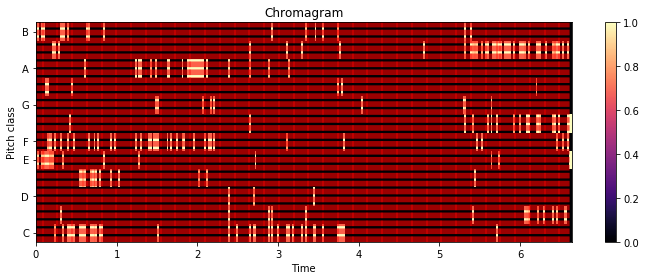

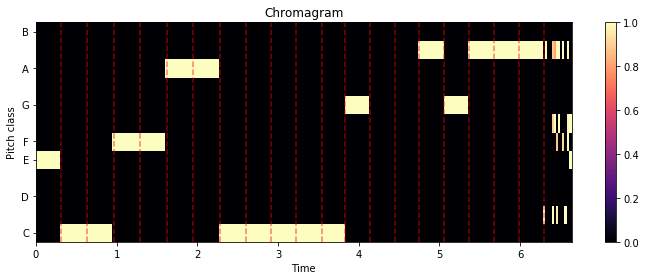

In [25]:
print(pool['tonal.hpcp'].T)
chroma = pool['tonal.hpcp'].T
#print(chroma.shape)


threshold = 300
m, n = chroma.shape

avg = 0
chroma = chroma.transpose()
m, n = chroma.shape

for j in chroma:
    avg = avg + np.sum(j)
    
avg = avg / m
threshold = avg

#print(threshold)

for i in chroma:
    if np.sum(i) > threshold:
        ind = np.where(i == np.max(i))
        max_val = i[ind]#is always 1!
        i[ind] = 0
        
        ind2 = np.where(i == np.max(i))
        i[ind] = 1
        
        if np.any(i[ind2] >= 0.6 * max_val):
            #i[ind2] = i[ind2]
            pass
        #low_values_flags = i < 1
        low_values_flags = i < 0.8
        
        i[low_values_flags] = 0
    else:
        i.fill(0)     
        
chroma = chroma.transpose()  
    
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.vlines(times / 2, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

chroma = chroma.transpose()  

        
chroma = chroma.transpose()     

tempo = bpm
times = beats
#print("Beat positions (sec.):", beats)
beats_frames = (beats * fs) / hopSize
beats_frames = beats_frames.astype(int)
#print("Beat positions (frame.):", beats_frames)
 

prev_beat = 0
act_beat = 0
sum_key = np.zeros(12)

chroma = chroma.transpose()  

for i in beats_frames:
    act_beat = i
    sum_key = sum(chroma[prev_beat:act_beat])
    #print(sum_key)
    #print(chroma[prev_beat:act_beat])

    ind = np.where(sum_key == np.max(sum_key))
    ind = ind[0]
    #print("debug")
    fill = np.zeros(len(j))
    if(np.all(chroma[prev_beat:act_beat] == 0)):
        fill[ind] = 0
    else:    
        fill[ind] = 1
    chroma[prev_beat:act_beat] = fill
    #print(chroma[prev_beat:act_beat])
    prev_beat = i
    #print("BEAT")


chroma = chroma.transpose()  
    
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.vlines(times / 2, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

chroma = chroma.transpose()  

notes = []
for i in notes:
    del i

for i in beats_frames:
    act_beat = i
    sum_key = sum(chroma[prev_beat:act_beat])
    ind = np.where(sum_key == np.max(sum_key))
    prev_beat = i
    notes.append(ind[0][0])
    
chroma = chroma.transpose()  

print(notes)



[[0.03844854 0.01373955 0.01124339 ... 0.01342248 0.00731866 0.        ]
 [0.         0.         0.         ... 1.         0.3723879  0.        ]
 [0.04788153 0.09153448 0.07495786 ... 0.10149667 0.08152706 0.19936337]
 ...
 [0.         0.48222736 0.5121375  ... 0.07957159 0.00728076 0.        ]
 [0.         0.         0.         ... 0.33647445 0.9925183  0.79346985]
 [0.79753804 1.         1.         ... 0.08148625 0.25838327 0.        ]]
(12, 286)
('Beat positions (sec.):', array([ 0.62693876,  1.2770975 ,  1.9272562 ,  2.577415  ,  3.2391837 ,
        3.9009523 ,  4.574331  ,  5.2012696 ,  5.8282084 ,  6.4551473 ,
        7.093696  ,  7.674195  ,  8.277914  ,  8.893243  ,  9.508572  ,
       10.1239    , 10.739229  , 11.354558  , 11.981497  , 12.596826  ],
      dtype=float32))
('Beat positions (frame.):', array([ 13,  27,  41,  55,  69,  84,  98, 111, 125, 139, 152, 165, 178,
       191, 204, 218, 231, 244, 258, 271]))


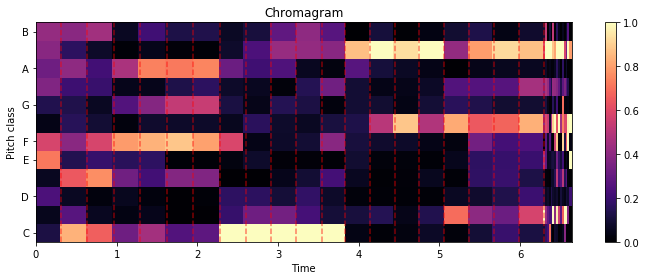

In [26]:
print(pool['tonal.hpcp'].T)
chroma = pool['tonal.hpcp'].T
print(chroma.shape)


threshold = 300
m, n = chroma.shape
    

tempo = bpm
times = beats
print("Beat positions (sec.):", beats)
beats_frames = (beats * fs) / hopSize
beats_frames = beats_frames.astype(int)
print("Beat positions (frame.):", beats_frames)
 

prev_beat = 0
act_beat = 0
sum_key = np.zeros(12)

chroma = chroma.transpose()  

for i in beats_frames:
    act_beat = i

    chroma[prev_beat:act_beat] = sum(chroma[prev_beat:act_beat])/(act_beat-prev_beat)
    #print(chroma[prev_beat:act_beat])
    prev_beat = i
    #print("BEAT")

chroma = chroma.transpose()  
    
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.vlines(times / 2, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()


